/tmp/ipykernel_821448/1449631539.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='H')


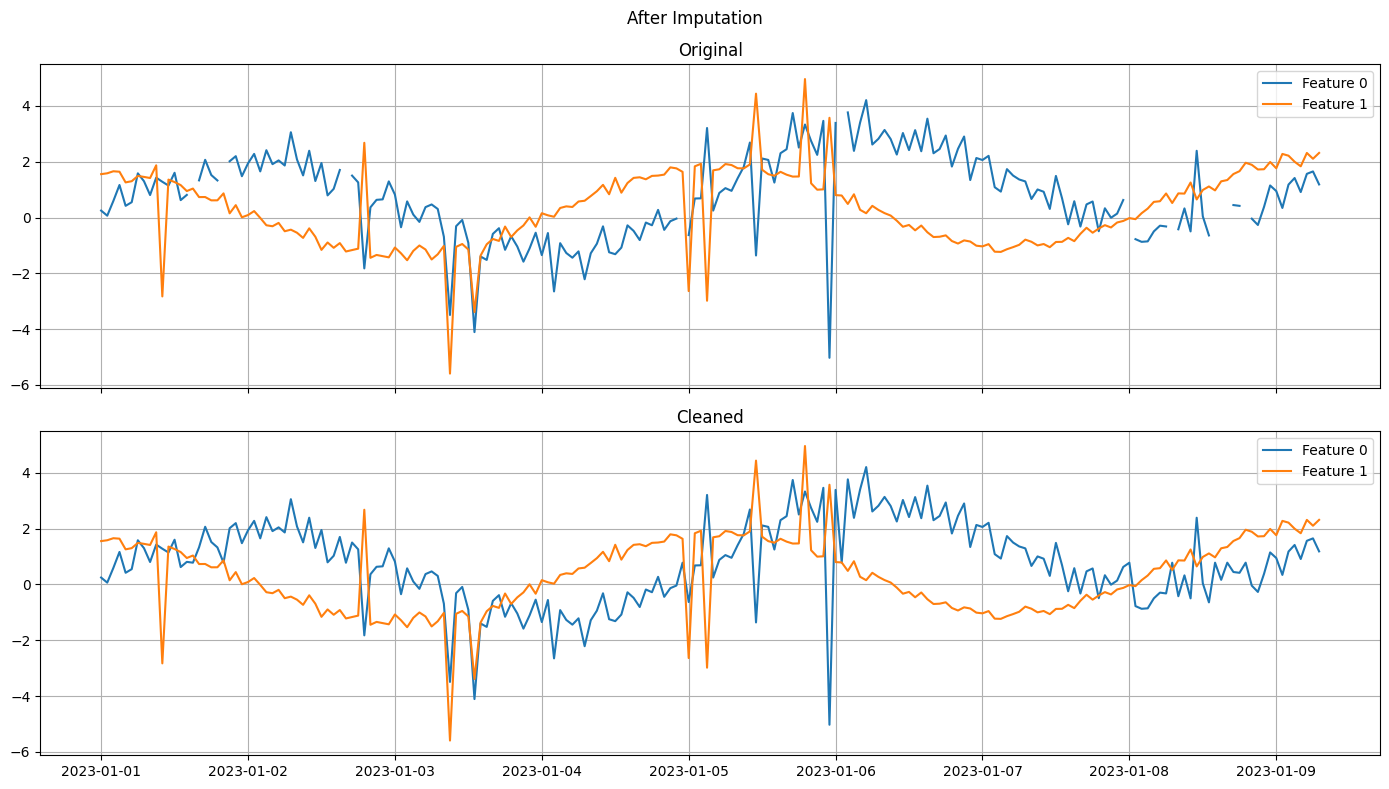

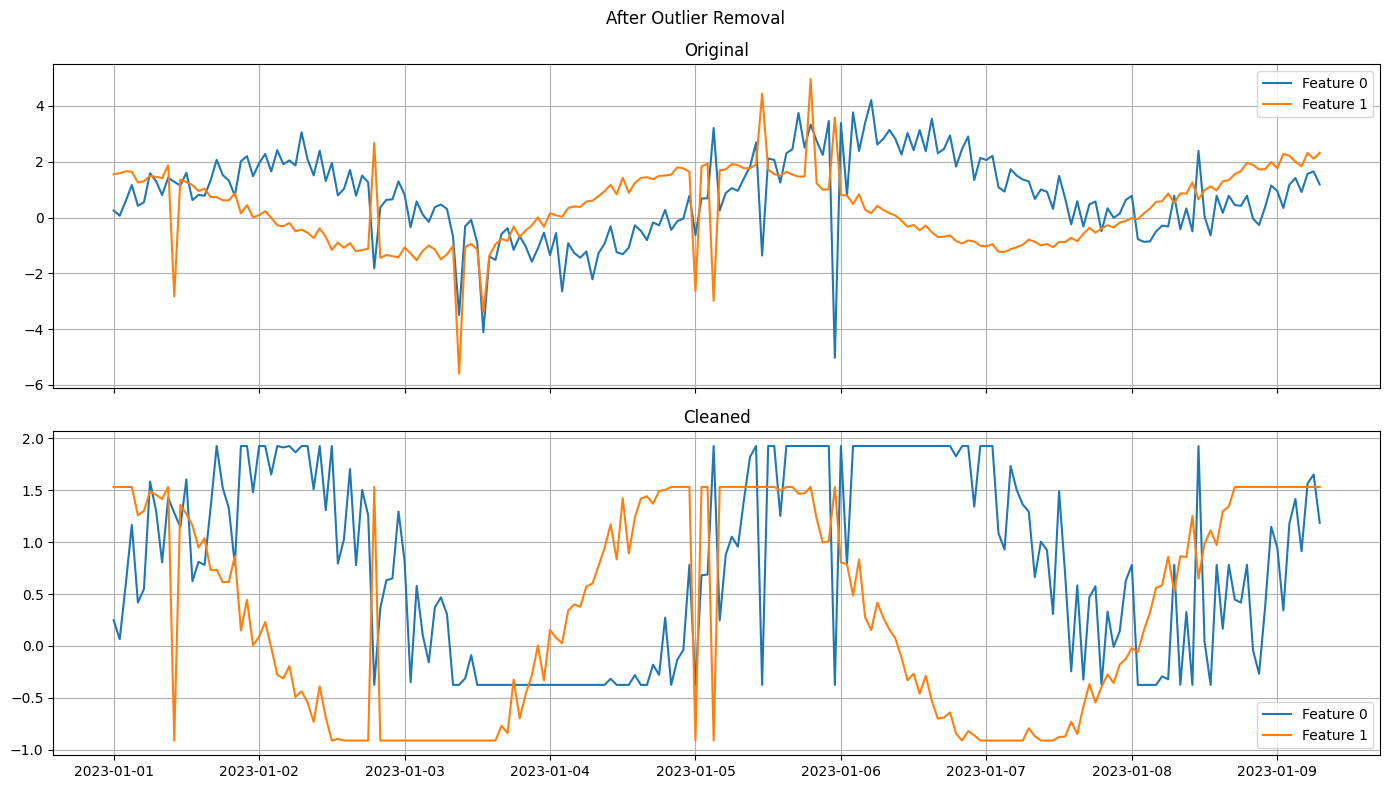

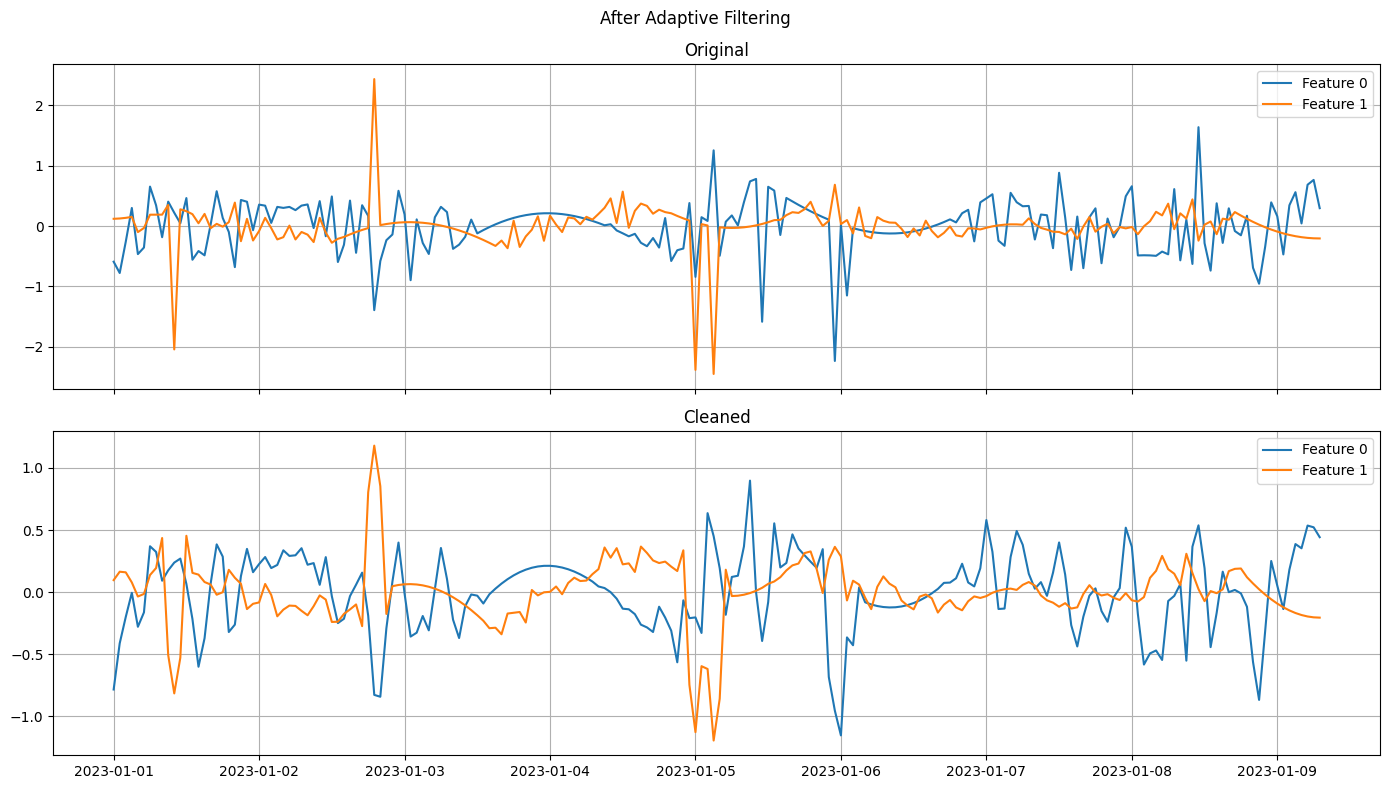

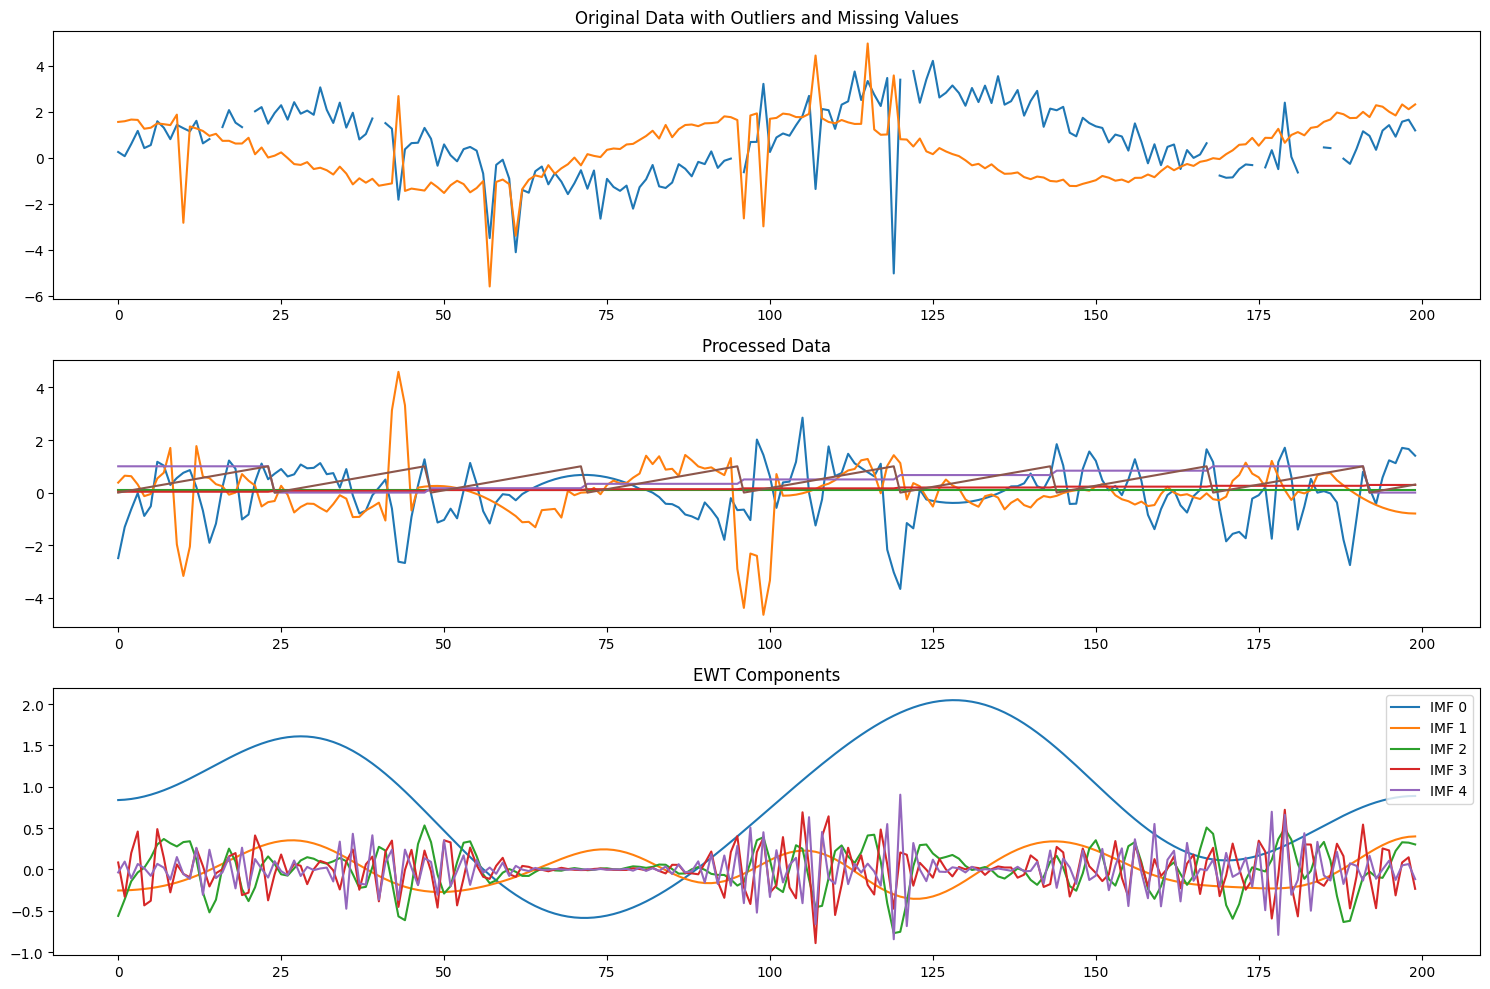

Input sequence shape: (165, 24, 6)
Target sequence shape: (165, 12, 6)


In [ ]:
foreblocks = __import__('foreblocks')

import importlib
importlib.reload(foreblocks)
from foreblocks import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
n_samples = 200
timestamps = pd.date_range(start='2023-01-01', periods=n_samples, freq='h')

# Create a time series with trend, seasonality, and noise
t = np.linspace(0, 4*np.pi, n_samples)
trend = 0.1 * t
seasonality1 = 2 * np.sin(t)  # Daily pattern
seasonality2 = 1 * np.sin(t/24)  # Weekly pattern
noise = np.random.normal(0, 0.5, n_samples)

# Combine components
data = (trend + seasonality1 + seasonality2 + noise).reshape(-1, 1)

# Create a second feature (to demonstrate multivariate capabilities)
data2 = (0.5 * trend + 1.5 * np.cos(t) + 0.5 * np.random.normal(0, 0.3, n_samples)).reshape(-1, 1)
data = np.hstack([data, data2])  # Now we have shape [n_samples, 2]

# Add some outliers
outlier_indices = np.random.choice(n_samples, 10, replace=False)
data[outlier_indices] = data[outlier_indices] + 5 * np.random.randn(10, 2)

# Add some missing values (but not too many)
missing_indices = np.random.choice(n_samples, 10, replace=False)
data[missing_indices, 0] = np.nan  # Only make some values missing in first feature

# Create preprocessor with various techniques enabled
preprocessor = TimeSeriesPreprocessor(
    normalize=True,
    differencing=False,
    detrend=True,
    apply_ewt=True,
    window_size=24,
    horizon=12,
    remove_outliers=True,
    outlier_threshold=0.05,
    outlier_method="iqr",
    impute_method="iterative",
    ewt_bands=5,
    trend_imf_idx=0,
    log_transform=False,
    filter_window=5,
    filter_polyorder=2,
    apply_filter=True
)

# Fit and transform the data
X, y, processed_data = preprocessor.fit_transform(data, time_stamps=timestamps)

# Visualize the results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('Original Data with Outliers and Missing Values')
plt.plot(data)

plt.subplot(3, 1, 2)
plt.title('Processed Data')
plt.plot(processed_data)

plt.subplot(3, 1, 3)
plt.title('EWT Components')
ewt_components = preprocessor.get_ewt_components()
if ewt_components:
    for i, imf in enumerate(ewt_components[0].T):
        plt.plot(imf, label=f'IMF {i}')
    plt.legend()

plt.tight_layout()
plt.show()

print(f"Input sequence shape: {X.shape}")
print(f"Target sequence shape: {y.shape}")

# TimeSeries

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, y_val)



Training:  34%|███▍      | 34/100 [00:01<00:03, 21.35epoch/s]

Training:  52%|█████▏    | 52/100 [00:02<00:02, 21.54epoch/s]

Epoch 50: Train Loss = 0.0096


Training: 100%|██████████| 100/100 [00:04<00:00, 20.95epoch/s]

Epoch 100: Train Loss = 0.0097


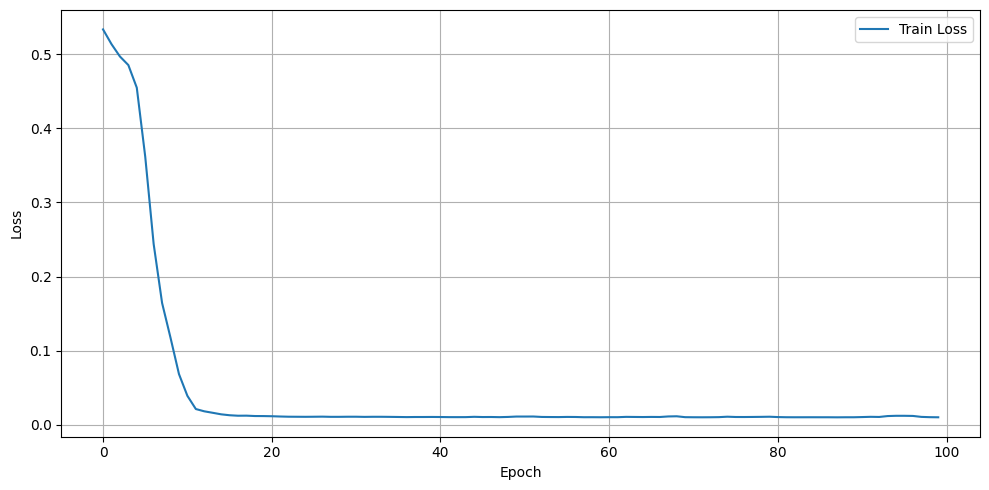

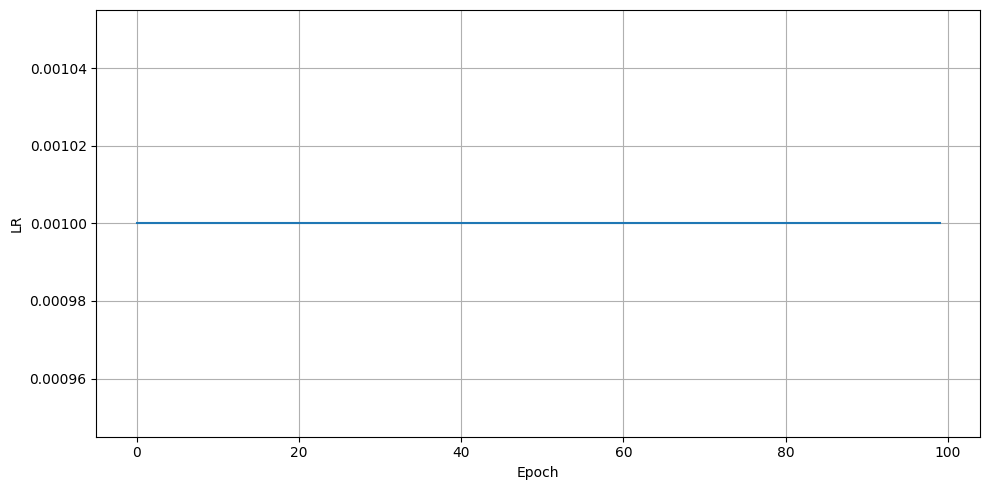

In [11]:
trainer.plot_learning_curves()


Validation Forecast Error Metrics:
  MSE   = 0.012356
  RMSE  = 0.111156
  MAE   = 0.089570


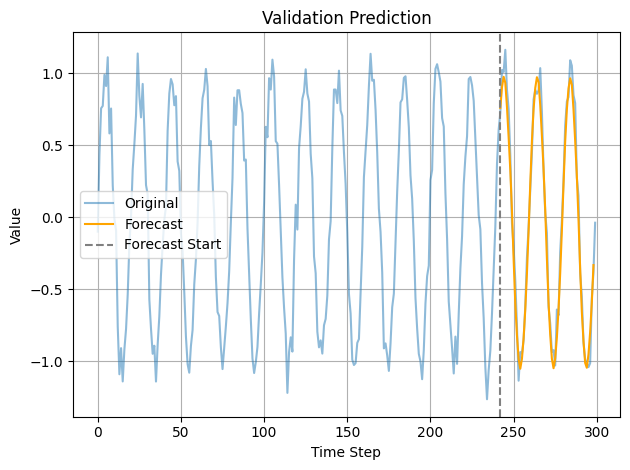


Validation Forecast Error Metrics:
  MSE   = 0.012356
  RMSE  = 0.111156
  MAE   = 0.089570


In [2]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)


# Transformer

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 300,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

attention_module = AttentionLayer(
    method=model_params.get("attention_method", "dot"),
    attention_backend=model_params.get(
        "attention_backend", "xformers"
    ),
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="transformer",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())
trainer.set_config('num_epochs', 100)
# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)




Attention method: dot, Attention backend: xformers


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]/home/seman/baseline/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 10, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/seman/baseline/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16, 10, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   1%|          | 1/100 [00:00<00:10,  9.64epoch/s]

Training:  51%|█████     | 51/100 [00:04<00:04, 11.62epoch/s]

Epoch 50: Train Loss = 0.0475


Training: 100%|██████████| 100/100 [00:08<00:00, 11.52epoch/s]

Epoch 100: Train Loss = 0.0470


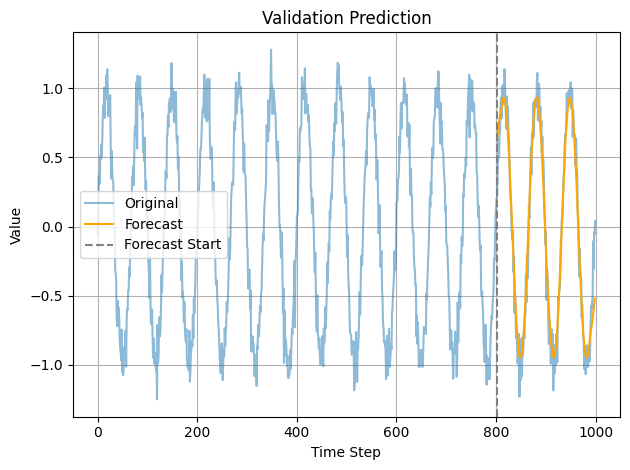

In [6]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)